In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from helper_functions import euclidean_distance
from helper_functions import contrastive_loss
from helper_functions import load_arrays
from helper_functions import plot_training
from helper_functions import load_and_split_data
from helper_functions import plot_confusion_matrix
from helper_functions import get_model_predictions
from helper_functions import plot_roc_curve
from helper_functions import plot_prec_rec_curve

# Load and prepare Data

### Load and create fast input pipeline with tf.data.dataset

In [3]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_10000.npz", "npz_datasets/data_y_10000.npz", split_size=80, batch_size=256)

CPU times: user 11.9 s, sys: 2.85 s, total: 14.8 s
Wall time: 14.8 s


In [61]:
%%time
train_dataset_rgb, test_dataset_rgb, val_dataset_rgb = load_and_split_data("npz_datasets/data_x_10000_rgb.npz", "npz_datasets/data_y_10000_rgb.npz", split_size=80, batch_size=256)

CPU times: user 36.4 s, sys: 8.46 s, total: 44.9 s
Wall time: 44.9 s


# Baseline Model

In [30]:
img_width = 224
img_height = 224

In [31]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(4, (3,3), activation="relu")(inputs)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(16, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(32, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_1 = keras.models.Model(inputs, outputs)

In [32]:
base_model_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 4)       40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 16)        592       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0   

In [33]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_1(img_a)
feat_vect_b = base_model_1(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [34]:
#Compile the model 
model_1 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_1.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [35]:
epochs=20
history_model_1 = model_1.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/20
32/32 [==============================] - 7s 208ms/step - loss: 0.3094 - accuracy: 0.4832 - val_loss: 0.2910 - val_accuracy: 0.4675
Epoch 2/20
32/32 [==============================] - 6s 204ms/step - loss: 0.2679 - accuracy: 0.5070 - val_loss: 0.2732 - val_accuracy: 0.4819
Epoch 3/20
32/32 [==============================] - 6s 203ms/step - loss: 0.2543 - accuracy: 0.5341 - val_loss: 0.2696 - val_accuracy: 0.4794
Epoch 4/20
32/32 [==============================] - 6s 203ms/step - loss: 0.2463 - accuracy: 0.5594 - val_loss: 0.2671 - val_accuracy: 0.4875
Epoch 5/20
32/32 [==============================] - 6s 204ms/step - loss: 0.2389 - accuracy: 0.5861 - val_loss: 0.2672 - val_accuracy: 0.4969
Epoch 6/20
32/32 [==============================] - 7s 205ms/step - loss: 0.2318 - accuracy: 0.6115 - val_loss: 0.2668 - val_accuracy: 0.4969
Epoch 7/20
32/32 [==============================] - 7s 205ms/step - loss: 0.2249 - accuracy: 0.6403 - val_loss: 0.2682 - val_accuracy: 0.4950
Epoch 

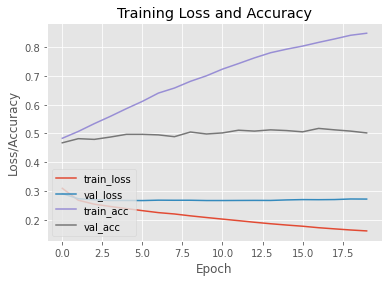

In [36]:
plot_training(history_model_1)

# Evaluate the model

In [37]:
model_1.evaluate(val_dataset)

2/2 [==============================] - 0s 81ms/step - loss: 0.2797 - accuracy: 0.4925


[0.2797412574291229, 0.4925000071525574]

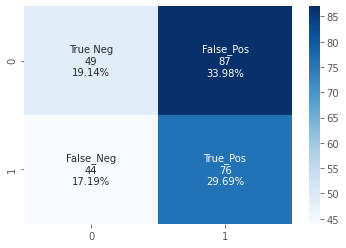

In [38]:
preds, labels = get_model_predictions(val_dataset, model_1)
plot_confusion_matrix(preds, labels)

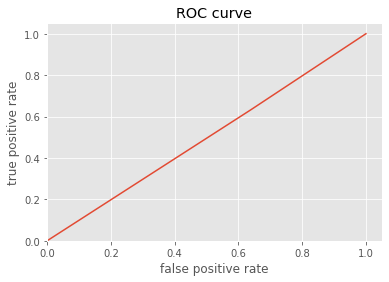

In [39]:
plot_roc_curve(preds, labels)

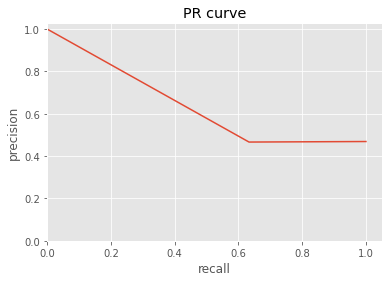

In [40]:
plot_prec_rec_curve(preds, labels)

# EfficientNetB0

In [41]:
img_width = 224
img_height = 224

In [42]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 1))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(64, activation="relu")(x)

base_model_2 = keras.models.Model(inputs, outputs)

In [43]:
base_model_2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
Total params: 4,738,275
Trainable params: 688,704
Non-trainable params: 4,049,571
_________________________________________________________________


In [44]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_2(img_a)
feat_vect_b = base_model_2(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [45]:
#Compile the model 
model_2 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_2.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [46]:
epochs=10
history_model_2 = model_2.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 22s 518ms/step - loss: 0.4625 - accuracy: 0.5016 - val_loss: 0.4112 - val_accuracy: 0.4819
Epoch 2/10
32/32 [==============================] - 15s 458ms/step - loss: 0.3646 - accuracy: 0.4843 - val_loss: 0.3586 - val_accuracy: 0.4650
Epoch 3/10
32/32 [==============================] - 15s 458ms/step - loss: 0.3449 - accuracy: 0.4806 - val_loss: 0.3395 - val_accuracy: 0.4669
Epoch 4/10
32/32 [==============================] - 15s 456ms/step - loss: 0.3257 - accuracy: 0.4840 - val_loss: 0.3208 - val_accuracy: 0.4719
Epoch 5/10
32/32 [==============================] - 15s 458ms/step - loss: 0.3172 - accuracy: 0.4832 - val_loss: 0.3194 - val_accuracy: 0.4769
Epoch 6/10
32/32 [==============================] - 15s 458ms/step - loss: 0.3166 - accuracy: 0.4845 - val_loss: 0.3186 - val_accuracy: 0.4756
Epoch 7/10
32/32 [==============================] - 15s 457ms/step - loss: 0.3160 - accuracy: 0.4831 - val_loss: 0.3180 - val_accuracy: 0.4756

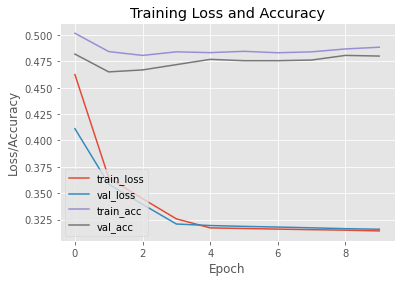

In [47]:
plot_training(history_model_2)

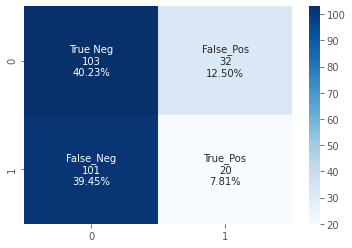

In [48]:
preds, labels = get_model_predictions(val_dataset, model_2)
plot_confusion_matrix(preds, labels)

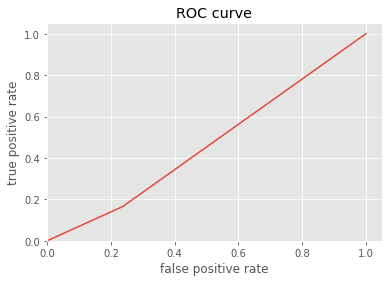

In [49]:
plot_roc_curve(preds, labels)

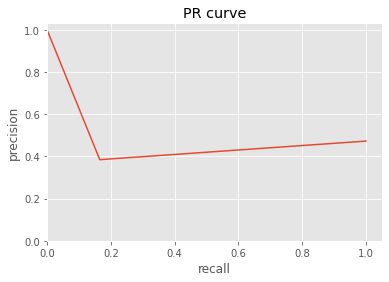

In [50]:
plot_prec_rec_curve(preds, labels)

# VGG 16

In [63]:
img_width = 224
img_height = 224

In [64]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(64, activation="relu")(x)

base_model_3 = keras.models.Model(inputs, outputs)

In [65]:
base_model_3.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
Total params: 15,010,176
Trainable params: 295,488
Non-trainable params: 14,714,688
_________________________________________________________________


In [66]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_3(img_a)
feat_vect_b = base_model_3(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [67]:
#Compile the model 
model_3 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_3.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [68]:
epochs=10
history_model_3 = model_3.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 37s 1s/step - loss: 0.2748 - accuracy: 0.4666 - val_loss: 0.2682 - val_accuracy: 0.4819
Epoch 2/10
32/32 [==============================] - 31s 979ms/step - loss: 0.2565 - accuracy: 0.5236 - val_loss: 0.2671 - val_accuracy: 0.4719
Epoch 3/10
32/32 [==============================] - 31s 977ms/step - loss: 0.2470 - accuracy: 0.5565 - val_loss: 0.2655 - val_accuracy: 0.4819
Epoch 4/10
32/32 [==============================] - 31s 981ms/step - loss: 0.2404 - accuracy: 0.5796 - val_loss: 0.2657 - val_accuracy: 0.4850
Epoch 5/10
32/32 [==============================] - 31s 976ms/step - loss: 0.2351 - accuracy: 0.6031 - val_loss: 0.2656 - val_accuracy: 0.4875
Epoch 6/10
32/32 [==============================] - 31s 976ms/step - loss: 0.2303 - accuracy: 0.6242 - val_loss: 0.2662 - val_accuracy: 0.4844
Epoch 7/10
32/32 [==============================] - 31s 979ms/step - loss: 0.2270 - accuracy: 0.6334 - val_loss: 0.2674 - val_accuracy: 0.4837
Ep

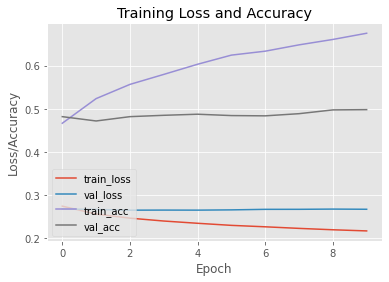

In [69]:
plot_training(history_model_3)

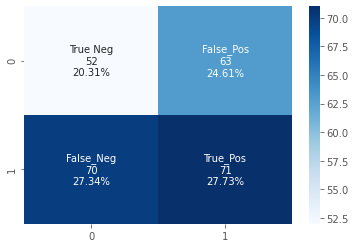

In [70]:
preds, labels = get_model_predictions(val_dataset_rgb, model_3)
plot_confusion_matrix(preds, labels)

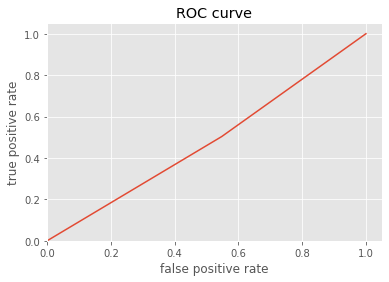

In [71]:
plot_roc_curve(preds, labels)

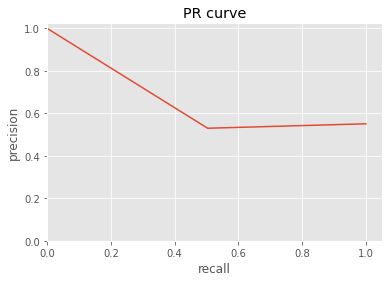

In [72]:
plot_prec_rec_curve(preds, labels)

# Resnet 101 V2

In [73]:
img_width = 224
img_height = 224

In [74]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.resnet_v2.ResNet101V2(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(64, activation="relu")(x)

base_model_4 = keras.models.Model(inputs, outputs)

In [75]:
base_model_4.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, None, None, 2048)  42626560  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
Total params: 43,708,480
Trainable params: 1,081,920
Non-trainable params: 42,626,560
_________________________________________________________________


In [76]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_4(img_a)
feat_vect_b = base_model_4(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [77]:
#Compile the model 
model_4 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_4.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [78]:
epochs=10
history_model_4 = model_4.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs)

Epoch 1/10
32/32 [==============================] - 45s 1s/step - loss: 0.5464 - accuracy: 0.4812 - val_loss: 0.3446 - val_accuracy: 0.5031
Epoch 2/10
32/32 [==============================] - 35s 1s/step - loss: 0.3133 - accuracy: 0.5135 - val_loss: 0.3474 - val_accuracy: 0.4806
Epoch 3/10
32/32 [==============================] - 35s 1s/step - loss: 0.3069 - accuracy: 0.5259 - val_loss: 0.3350 - val_accuracy: 0.4888
Epoch 4/10
32/32 [==============================] - 35s 1s/step - loss: 0.2872 - accuracy: 0.5611 - val_loss: 0.3331 - val_accuracy: 0.5025
Epoch 5/10
32/32 [==============================] - 35s 1s/step - loss: 0.2680 - accuracy: 0.5830 - val_loss: 0.3571 - val_accuracy: 0.4900
Epoch 6/10
32/32 [==============================] - 35s 1s/step - loss: 0.2416 - accuracy: 0.6279 - val_loss: 0.3682 - val_accuracy: 0.4825
Epoch 7/10
32/32 [==============================] - 35s 1s/step - loss: 0.2486 - accuracy: 0.6241 - val_loss: 0.3424 - val_accuracy: 0.5000
Epoch 8/10
32/32 [==

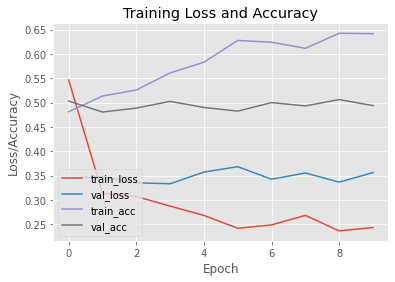

In [79]:
plot_training(history_model_4)

In [ ]:
#to do - plot confusion matrix - weird error here

# Alexnet - from Scratch

In [84]:
img_width = 224
img_height = 224

In [101]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(96, (11,11), strides=4, padding="same")(inputs)
x = keras.layers.Lambda(tf.nn.local_response_normalization)(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPool2D((3,3), strides=2)(x)

x = keras.layers.Conv2D(256, (5,5), strides=4, padding="same")(x)
x = keras.layers.Lambda(tf.nn.local_response_normalization)(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPool2D((3,3), strides=2)(x)

x = keras.layers.Conv2D(384, (3,3), strides=4, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(384, (3,3), strides=4, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(256, (3,3), strides=4, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(4096, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(4096, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_5 = keras.models.Model(inputs, outputs)

In [102]:
base_model_5.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 56, 56, 96)        11712     
_________________________________________________________________
lambda_15 (Lambda)           (None, 56, 56, 96)        0         
_________________________________________________________________
activation_15 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_16 (Lambda)           (None, 7, 7, 256)         0  

In [103]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_5(img_a)
feat_vect_b = base_model_5(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [104]:
#Compile the model 
model_5 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_5.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [110]:
epochs=10
history_model_5 = model_5.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=2)])

Epoch 1/10
32/32 [==============================] - 13s 396ms/step - loss: 0.2537 - accuracy: 0.5017 - val_loss: 0.5165 - val_accuracy: 0.4831
Epoch 2/10
32/32 [==============================] - 13s 397ms/step - loss: 0.2546 - accuracy: 0.4976 - val_loss: 0.5165 - val_accuracy: 0.4831
Epoch 3/10
32/32 [==============================] - 13s 397ms/step - loss: 0.2530 - accuracy: 0.5038 - val_loss: 0.5165 - val_accuracy: 0.4831

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.5600003020209705e-11.
Epoch 4/10
32/32 [==============================] - 13s 400ms/step - loss: 0.2532 - accuracy: 0.4979 - val_loss: 0.5165 - val_accuracy: 0.4831
Epoch 5/10
32/32 [==============================] - 13s 402ms/step - loss: 0.2540 - accuracy: 0.5024 - val_loss: 0.5165 - val_accuracy: 0.4831

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.2800001510104853e-11.
Epoch 6/10
32/32 [==============================] - 13s 399ms/step - loss: 0.2546 - accuracy: 0.4971 - val_loss: 0.5165 -

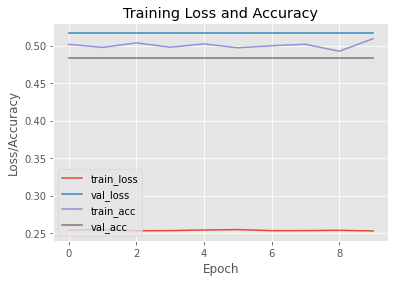

In [111]:
plot_training(history_model_5)

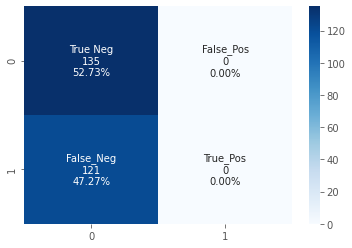

In [112]:
preds, labels = get_model_predictions(val_dataset, model_5)
plot_confusion_matrix(preds, labels)

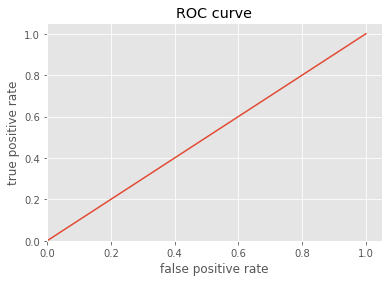

In [113]:
plot_roc_curve(preds, labels)

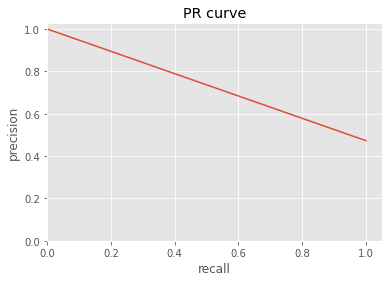

In [114]:
plot_prec_rec_curve(preds, labels)

# Model from Scratch

In [5]:
img_width = 224
img_height = 224

In [80]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(8, (2,2), activation="relu")(inputs)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(8, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(16, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(32, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(64, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(128, activation="relu")(x)

base_model_6 = keras.models.Model(inputs, outputs)

In [81]:
base_model_6.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 223, 223, 8)       40        
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 110, 110, 8)       264       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 54, 54, 16)        528       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 27, 27, 16)        0  

In [82]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_6(img_a)
feat_vect_b = base_model_6(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [83]:
#Compile the model 
model_6 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_6.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [84]:
epochs=150
history_model_6 = model_6.fit(train_dataset, validation_data=test_dataset, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)])

Epoch 1/150
32/32 [==============================] - 7s 219ms/step - loss: 0.2433 - accuracy: 0.5019 - val_loss: 0.2390 - val_accuracy: 0.4837
Epoch 2/150
32/32 [==============================] - 7s 217ms/step - loss: 0.2341 - accuracy: 0.5225 - val_loss: 0.2344 - val_accuracy: 0.5194
Epoch 3/150
32/32 [==============================] - 7s 217ms/step - loss: 0.2310 - accuracy: 0.5537 - val_loss: 0.2323 - val_accuracy: 0.5425
Epoch 4/150
32/32 [==============================] - 7s 214ms/step - loss: 0.2285 - accuracy: 0.5759 - val_loss: 0.2304 - val_accuracy: 0.5644
Epoch 5/150
32/32 [==============================] - 7s 218ms/step - loss: 0.2264 - accuracy: 0.5931 - val_loss: 0.2283 - val_accuracy: 0.5788
Epoch 6/150
32/32 [==============================] - 7s 220ms/step - loss: 0.2242 - accuracy: 0.6077 - val_loss: 0.2262 - val_accuracy: 0.5881
Epoch 7/150
32/32 [==============================] - 7s 216ms/step - loss: 0.2216 - accuracy: 0.6211 - val_loss: 0.2244 - val_accuracy: 0.5944

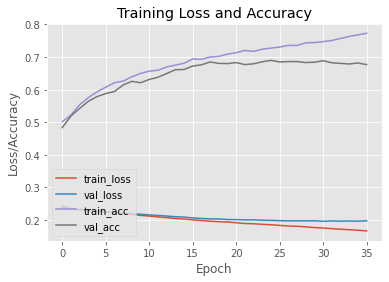

In [85]:
plot_training(history_model_6)

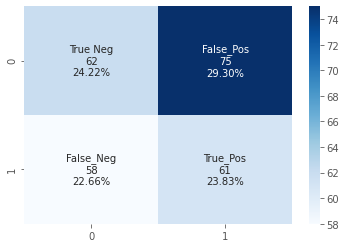

In [86]:
preds, labels = get_model_predictions(val_dataset, model_6)
plot_confusion_matrix(preds, labels)

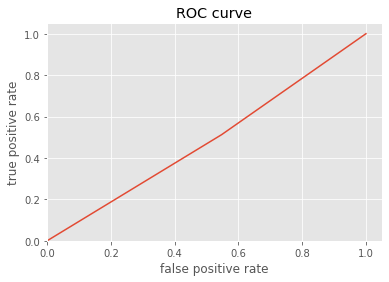

In [87]:
plot_roc_curve(preds, labels)

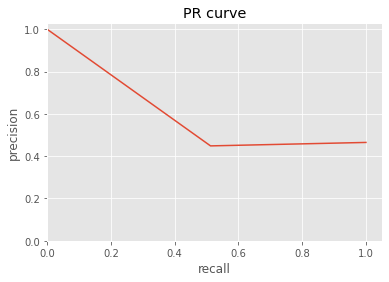

In [88]:
plot_prec_rec_curve(preds, labels)